# An Apriori Algorithm Implementation
Elisabetta Rocchetti - Algorithms for Massive Datasets Project

## Library installation and inclusion

In [5]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install kaggle --upgrade

In [3]:
import os
import pandas as pd
import numpy as np
import itertools
from nltk.tokenize import RegexpTokenizer
from google.colab import drive 
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

### Spark initialization

In [6]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

In [7]:
import findspark
findspark.init("spark-2.4.8-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

## Dataset download

In [ ]:
os.environ["KAGGLE_USERNAME"] = "elisabettarocchetti0"
os.environ["KAGGLE_KEY"] = "daf7c0dd91ac8813e24d726715b6075b"

In [ ]:
!kaggle datasets list --tags business,internet,news,history,linguistics

ref                       title           size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------  --------------  ----  -------------------  -------------  ---------  ---------------  
alvations/old-newspapers  Old Newspapers   2GB  2020-05-12 04:18:43           2612         74  0.7058824        


In [ ]:
!kaggle datasets download alvations/old-newspapers --unzip

 99% 2.03G/2.05G [00:30<00:00, 73.0MB/s]
100% 2.05G/2.05G [00:30<00:00, 72.8MB/s]


In [ ]:
data = pd.read_csv("/content/old-newspaper.tsv", sep ="\t").loc[data['Language'] == "Italian", "Text"][:500]
data.head()

### Saving data in Google Drive for faster future executions

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/data_italian.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  data.to_csv(f, index = False)


### Loading data from Google Drive to avoid downloading data each time

In [8]:
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/data_italian.csv')["Text"][:500]
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0    con l'editore Crocetti Il poeta e drammaturgo ...
1                          Angoli: 7 a 2 per il Lecce.
2    CANTU', 26 dicembre – Quattro giorni dopo il t...
3    Certo, alla fine s'é deciso per una donna, una...
4    TOKYO LANCIA L'ASIA La Borsa giapponese di Tok...
Name: Text, dtype: object

## First implementation

### Pre-processing

In [34]:
rdd_dataset = sc.parallelize(data)

In [35]:
custom_tokenizer = RegexpTokenizer('\w+')

In [36]:
rdd_dataset = (rdd_dataset.map(lambda txt: list(set(custom_tokenizer
                                                    .tokenize(txt.lower().strip())))))

### First pass

In [38]:
rdd = (rdd_dataset.flatMap(lambda txt: txt)
                .map(lambda word: (word,1))
                .reduceByKey(lambda w1, w2: 1)
                .map(lambda x: x[0])
                .collect())
dictionary = dict(zip(rdd, range(len(rdd))))

In [39]:
def getIndex(txt):
  word_list = []
  for word in txt:
    i = dictionary[word]
    if i not in word_list:
      word_list = word_list + [i]
  return word_list

In [40]:
rdd_coded_flattened = rdd_dataset.flatMap(getIndex)

In [41]:
count_singletons = (rdd_coded_flattened.map(lambda x: (x, 1))
                                    .reduceByKey(lambda x1, x2: x1+x2))

### Between the passes

In [42]:
s = len(dictionary) * 0.01

In [43]:
count_frequent_singletons = count_singletons.filter(lambda x: x[1]>s).collect()

In [44]:
frequent_items_table = np.zeros(len(dictionary))
for c, item in enumerate(count_frequent_singletons):
  frequent_items_table[item[0]] = c+1

### Second Pass

In [46]:
def filterFrequent(words):
  r = []
  for w in words:
    if frequent_items_table[w] != 0:
      r = r + [w]
  return r

In [47]:
def generatePairs(words):
  r = []
  for i in range(len(words)):
    for j in range(i+1, len(words)):
      r = r + [((words[i], words[j]),1)]
  return r

In [48]:
rdd_coded = rdd_dataset.map(getIndex)

In [49]:
count_pairs = (rdd_coded.map(filterFrequent)
                    .filter(lambda x : len(x)>1)
                    .flatMap(generatePairs)
                    .reduceByKey(lambda x1, x2 : x1 + x2))

In [50]:
count_frequent_pairs = count_pairs.filter(lambda x: x[1]>s).collect()

In [ ]:
count_frequent_pairs

## Final implementation

In [19]:
def createDictionary(rdd_dataset, tokenizer):
  rdd = (rdd_dataset.flatMap(lambda txt: txt)
                  .map(lambda word: (word,1))
                  .reduceByKey(lambda w1, w2: 1)
                  .map(lambda x: x[0])
                  .collect())
  dictionary = dict(zip(rdd, range(len(rdd))))
  return dictionary   

In [20]:
class Indexer():
  def __init__(self, tokenizer, dictionary):
    self.tokenizer = tokenizer
    self.dictionary = dictionary
    self.reverse_dictionary = dict((y,x) for x,y in dictionary.items())

  def getIndex(self, txt):
    word_list = []
    for word in txt:
      i = self.dictionary[word]
      if i not in word_list:
        word_list = word_list + [i]
    return word_list
  
  def getWord(self, coded):
    new_k = []
    if type(coded[0]) != int:
      for k in coded[0]:
        new_k = new_k + [self.reverse_dictionary[k]]
      return (tuple(new_k), coded[1])
    else: return (self.reverse_dictionary[coded[0]], coded[1])
    

In [21]:
class FrequentItemSets():
  def __init__(self, dict_size):
    self.frequent_itemsets = np.zeros(dict_size)
    self.dictionary_size = dict_size

  def filterFrequent(self, words):
    r = []
    for w in words:
      if self.frequent_itemsets[w] != 0:
        r = r + [w]
    return r
  
  def getFrequentItemSets(self):
    return self.frequent_itemsets

  def setFrequentItemSets(self, frequent_itemsets):
    self.frequent_itemsets = np.zeros(self.dictionary_size)
    i = 0
    for item in frequent_itemsets:
      if type(item[0]) == tuple:
        for el in item[0]:
          i = i+1
          self.frequent_itemsets[el] = i
      else:
        i = i+1
        self.frequent_itemsets[item[0]] = i
  

In [22]:
class SubSetter():
  def __init__(self, n = 2):
    self.subset_size = n
  def findSubSets(self, words):
    return list(itertools.combinations(words, self.subset_size))
  def generateSubSets(self, words):
    l = self.findSubSets(words)
    r = [(item,1) for item in l]
    return r

In [23]:
def apriori(dataset, itemset_size, tokenizer, threshold, coded = False):
  rdd_dataset = sc.parallelize(dataset)
  rdd_dataset = (rdd_dataset.map(lambda txt: list(set(tokenizer
                                                      .tokenize(txt
                                                                .lower()
                                                                .strip())))))
  dictionary = createDictionary(rdd_dataset, tokenizer)
  threshold = len(dictionary) * threshold
  indexer = Indexer(tokenizer, dictionary)
  results = []

  rdd_coded = rdd_dataset.map(indexer.getIndex)
  rdd_coded_flattened = rdd_dataset.flatMap(indexer.getIndex)

  frequentItemsets = FrequentItemSets(len(dictionary))
  i = 1
  iterate = True
  while(iterate):
    if i == 1:
      count_frequent_singletons = (rdd_coded_flattened
                                        .map(lambda x: (x, 1))
                                        .reduceByKey(lambda x1, x2: x1+x2)
                                        .filter(lambda x: x[1] > threshold))
      frequentItemsets.setFrequentItemSets(count_frequent_singletons.collect())
      if coded:
        results.append(count_frequent_singletons.map(indexer.getWord))
      else: results.append(count_frequent_singletons)

    else:
      subsetter = SubSetter(i)
      count_frequent_kItemSets = (rdd_coded.map(frequentItemsets.filterFrequent)
                                        .filter(lambda x : len(x)>=i)
                                        .flatMap(subsetter.generateSubSets)
                                        .reduceByKey(lambda x1, x2 : x1 + x2)
                                        .filter(lambda x: x[1] > threshold))
      frequentItemsets.setFrequentItemSets(count_frequent_kItemSets.collect())
      if coded:
        results.append(count_frequent_kItemSets.map(indexer.getWord))
      else: results.append(count_frequent_kItemSets)
    
    i = i+1
    if ((itemset_size == "no-stop" and len(results[-1].collect()) == 0) or 
        (itemset_size != "no-stop" and i > itemset_size)):
      iterate = False
  
  return results  

## Experiments

### Singletons

In [68]:
tokenizer = RegexpTokenizer('\w+')
threshold = 0.01
start = time.time()
result = apriori(data, 1, tokenizer, threshold, True)
end = time.time()
print("Execution time: {}".format(end - start))
print(result[-1].collect()[:10])

Execution time: 0.6929306983947754
[('un', 236), ('a', 299), ('di', 377), ('che', 281), ('con', 178), ('da', 152), ('ha', 147), ('del', 245), ('alla', 109), ('in', 283)]


### Pairs

In [69]:
tokenizer = RegexpTokenizer('\w+')
threshold = 0.01
start = time.time()
result = apriori(data, 2, tokenizer, threshold, True)
end = time.time()
print("Execution time: {}".format(end - start))
print(result[-1].collect()[:10])

Execution time: 1.2077643871307373
[(('un', 'di'), 116), (('il', 'l'), 186), (('il', 'la'), 243), (('il', 'e'), 251), (('il', 'per'), 197), (('l', 'la'), 187), (('l', 'e'), 192), (('l', 'per'), 149), (('la', 'e'), 249), (('la', 'per'), 181)]


### Triplets

In [70]:
tokenizer = RegexpTokenizer('\w+')
threshold = 0.01
start = time.time()
result = apriori(data, 3, tokenizer, threshold, True)
end = time.time()
print("Execution time: {}".format(end - start))
print(result[-1].collect()[:10])

Execution time: 1.787541389465332
[(('il', 'l', 'la'), 153), (('il', 'l', 'e'), 159), (('il', 'l', 'per'), 123), (('il', 'la', 'e'), 206), (('il', 'la', 'per'), 152), (('il', 'a', 'di'), 219), (('il', 'a', 'che'), 182), (('il', 'a', 'con'), 119), (('il', 'di', 'che'), 182), (('il', 'di', 'con'), 139)]


### 4-tuples

In [71]:
tokenizer = RegexpTokenizer('\w+')
threshold = 0.01
start = time.time()
result = apriori(data, 4, tokenizer, threshold, True)
end = time.time()
print("Execution time: {}".format(end - start))
print(result[-1].collect()[:10])

Execution time: 3.6831672191619873
[(('il', 'l', 'la', 'e'), 134), (('il', 'l', 'la', 'per'), 104), (('il', 'l', 'e', 'per'), 107), (('il', 'la', 'e', 'per'), 133), (('il', 'a', 'di', 'e'), 184), (('il', 'a', 'di', 'per'), 143), (('il', 'a', 'che', 'e'), 158), (('il', 'a', 'che', 'per'), 121), (('il', 'di', 'che', 'e'), 159), (('il', 'di', 'che', 'per'), 122)]


### Until no itemset is frequent

In [72]:
tokenizer = RegexpTokenizer('\w+')
threshold = 0.01
start = time.time()
result = apriori(data, "no-stop", tokenizer, threshold, True)
end = time.time()
print("Execution time: {}".format(end - start))
for i in range(len(result)):
  print("Itemset size: {}".format(i+1))
  print(result[i].collect()[:2])

Execution time: 10.732781648635864
Itemset size: 1
[('un', 236), ('a', 299)]
Itemset size: 2
[(('un', 'di'), 116), (('il', 'l'), 186)]
Itemset size: 3
[(('il', 'l', 'la'), 153), (('il', 'l', 'e'), 159)]
Itemset size: 4
[(('il', 'l', 'la', 'e'), 134), (('il', 'l', 'la', 'per'), 104)]
Itemset size: 5
[(('il', 'l', 'la', 'e', 'per'), 93), (('il', 'a', 'di', 'e', 'per'), 127)]
Itemset size: 6
[(('il', 'a', 'di', 'che', 'in', 'e'), 107), (('il', 'del', 'di', 'che', 'in', 'e'), 95)]
Itemset size: 7
[]


### Automatic testing

In [30]:
tokenizer = RegexpTokenizer('\w+')
max_itemset_size = [1, 2, 3, 4, 5, "no-stop"]
thresholds = [0.1, 0.05, 0.01]
timings = dict()
for threshold in tqdm(thresholds):
  t = []
  for itemset_size in max_itemset_size:
    t_1 = []
    for i in range(5):
      start = time.time()
      result = apriori(data, itemset_size, tokenizer, threshold, True)
      end = time.time()
      t_1.append(end-start)
    t.append(np.median(t_1))
  timings[threshold] = t

100%|██████████| 3/3 [02:55<00:00, 58.33s/it]


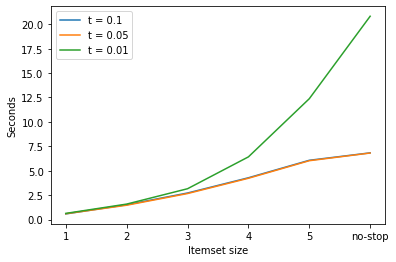

In [31]:
vertical = max_itemset_size
x = np.cumsum(timings[0.1])
y = np.cumsum(timings[0.05])
z = np.cumsum(timings[0.01])

plt.plot(vertical, x, label = "t = 0.1")
plt.plot(vertical, y, label = "t = 0.05")
plt.plot(vertical, z, label = "t = 0.01")

plt.xlabel("Itemset size")
plt.ylabel("Seconds")

plt.legend()

plt.show()

## Real-world application: market-basket analysis
In order to do market-basket analysis, two important measures must be computed: confidence and interest.

In [55]:
def containsI(elem):
  for i in I:
    if i not in elem[0]:
      return False
  return True

def containsIj(elem):
  for i in (I+[j]):
    if i not in elem[0]:
      return False
  return True

In [56]:
def computeConfidenceAndInterest():
    k = len(I)
    result = apriori(data, k+1, tokenizer, threshold, True)
    number_I, number_Ij, number_j = 0, 0, 0
    try:
      number_I = list(dict(result[-2].filter(containsI).collect()).values())[0]
    except IndexError:
        return "No itemset containing I"
    try:
      number_Ij = list(dict(result[-1].filter(containsIj).collect()).values())[0]
    except IndexError:
      pass
    try:
      number_j = list(dict(result[0].filter(lambda x: x[0]==j).collect()).values())[0]
    except IndexError:
      pass
    confidence = number_Ij/number_I
    interest = confidence - (number_j/len(data))
    return (confidence, interest)

In [53]:
tokenizer = RegexpTokenizer('\w+')
threshold = 0.01

In [63]:
I = ['di', 'e', 'che']
j = 'per'

In [64]:
start = time.time()
result = computeConfidenceAndInterest(data, I, j, threshold)
end = time.time()

In [65]:
print("Execution time: {}".format(end - start))
if type(result) == tuple:
  print("Confidence: {}".format(confidence))
  print("Interest: {}".format(interest))
else:
  print("Confidence could not be computed because no itemsets contain I")

Execution time: 4.007106781005859
Confidence: 0.6827956989247311
Interest: 0.18479569892473113
